# Building CNN model for predicting MOE and MOR of wood in the transverse direction

## 1. import all necessary libraries

In [1]:
#! conda install tensorflow
# 导入自定义模块和必要的库

from common.modules import *



In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'# 禁用CUDA，使得TensorFlow在CPU上运行
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
"""
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
import h5py

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
else:
    print("TensorFlow is using CPU")
    
"""
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
"""    


Num GPUs Available:  1
TensorFlow is using GPU


'\nif tf.test.gpu_device_name():\n    print(\'Default GPU Device: {}\'.format(tf.test.gpu_device_name()))\nelse:\n    print("Please install GPU version of TF")\n'

## 2. read database

In [3]:
# 数据文件的路径
h5_path_ = "database.h5"
f = h5py.File(h5_path_, 'r')
mydata=hdfRead()
_, img_path=mydata.list_contents(f)

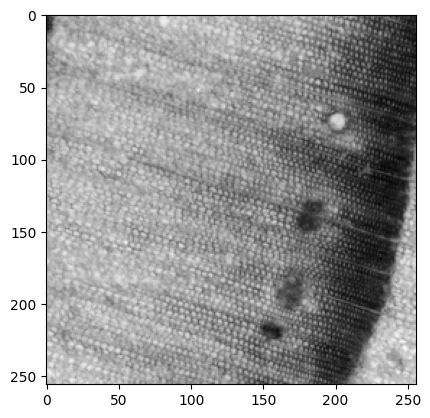

In [4]:
# load first image (256 X 256) 加载并显示第一张图像 (256 X 256)
img = f[img_path[0]]
plt.imshow(img, cmap='gray')

In [5]:
# 加载并打印对应的属性（密度、弹性模量、抗弯强度、细胞定向）
# load respetive information (density, modulus of elasticity, modulus of rupture, orientation of parenchyma cell)
print(f[img_path[0]].attrs['Density'],
      f[img_path[0]].attrs['MOE'],
      f[img_path[0]].attrs['MOR'],
      f[img_path[0]].attrs['ORP'])

0.41349162519926547 286.1611143382518 3.575741191312968 17.69048818923406


## 3. Train MOE

In [6]:
# 初始化数据列表
X = [] # 用于存储图像
Y = [] # 用于存储弹性模量（MOE）

# 遍历并处理图像和标签数据
for i in tqdm(range(len(img_path))):
    img=f[img_path[i]]
    #img_resized = tf.image.resize(img, [256, 256])  # 调整图像大小为256x256
    X.append(standardize(np.asarray(img)))# 标准化图像并添加到X列表
    Y.append(f[img_path[i]].attrs['MOE'])# 添加MOE值到Y列表


    # 将列表转换为NumPy数组
X = np.asarray(X)
Y = np.asarray(Y)
X.shape
   


100%|███████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 930.05it/s]


(223, 256, 256, 1)

In [7]:
###############################################################
# 转换图像为三通道
"""
def convert_to_rgb(images):
    rgb_images = np.stack([images, images, images], axis=-1)
    return rgb_images

X = convert_to_rgb(X)
"""

X.shape

(223, 256, 256, 1)

In [8]:
# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(Y), test_size=0.2, random_state=0)

In [9]:

# 定义并打印模型概况
###########################

# X_train_rgb = convert_to_rgb(X_train)
# X_test_rgb = convert_to_rgb(X_test)
#######################
if X_train.ndim == 5 and X_train.shape[3] == 1:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[4]))

# 同样的操作对 X_test 进行
if X_test.ndim == 5 and X_test.shape[3] == 1:
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[4]))


input_shape = X_train.shape[1:]
input_shape
#X_train = np.repeat(X_train, 3, axis=-1)




model = model(input_shape)



"""
# 定义ResNet18模型
model = model(input_shape=X_train.shape[1:], classes=1)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])"""

"\n# 定义ResNet18模型\nmodel = model(input_shape=X_train.shape[1:], classes=1)\nmodel.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])"

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 416         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           activation[0][0]                 
______________________________________________________________________________________________

In [11]:
# 设置模型保存路径和回调函数
checkpoint_filepath = 'MOE.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               save_best_only=True)
"""

checkpoint = ModelCheckpoint(
    'MOE.h5',
    monitor='val_loss',  # 监控验证集上的损失
    verbose=1,           # 打印详细日志
    save_best_only=True, # 只保存最好的模型
    mode='min',          # 最小化监控指标
    save_weights_only=True
)
"""
# 定义优化器并编译模型
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


import tensorflow as tf
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

# 编译模型时添加自定义指标
model.compile(loss='mse', optimizer=optimizer, metrics=[r_squared, 'mse', 'mae'])


# model.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
# 训练模型
history = model.fit(X_train, y_train, validation_split=0.1, verbose=0, epochs=1000, callbacks=[model_checkpoint_callback, PrintDot()])

# model.save_weights('MOE_final.h5')
                                            #history = model.fit(X_train, y_train, validation_split=0.1, epochs=1000, callbacks=[model_checkpoint_callback, PrintDot()], verbose=0)


 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
................................................................................

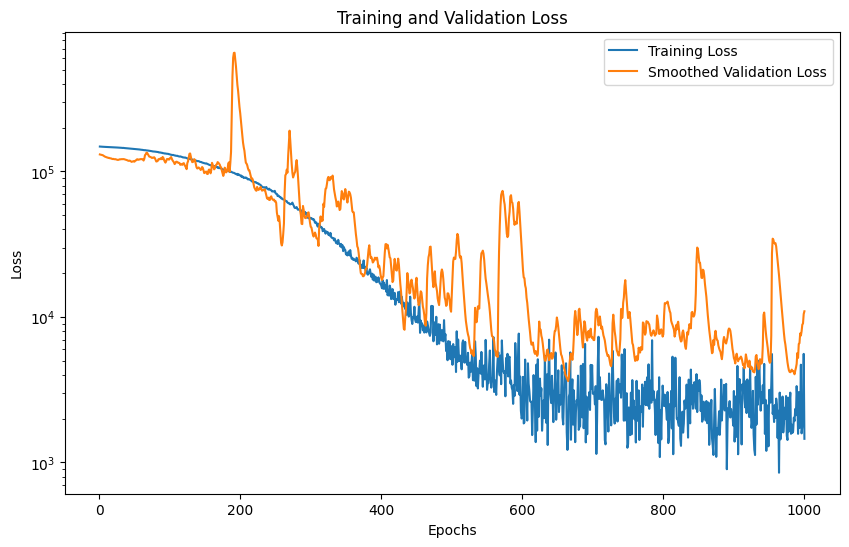

"\nplt.figure(figsize=(10, 6))\nplt.plot(history.history['loss'], label='Training Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.title('Model Loss During Training')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend()\nplt.show()\n"

In [12]:
# 绘制训练和验证损失
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# 获取损失值
loss = history.history['loss']
val_loss = history.history['val_loss']

smoothed_val_loss = smooth_curve(val_loss)

# 绘制平滑后的验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(smoothed_val_loss) + 1), smoothed_val_loss, label='Smoothed Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # 设置 y 轴为对数尺度
plt.legend()
plt.show()
"""
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
"""

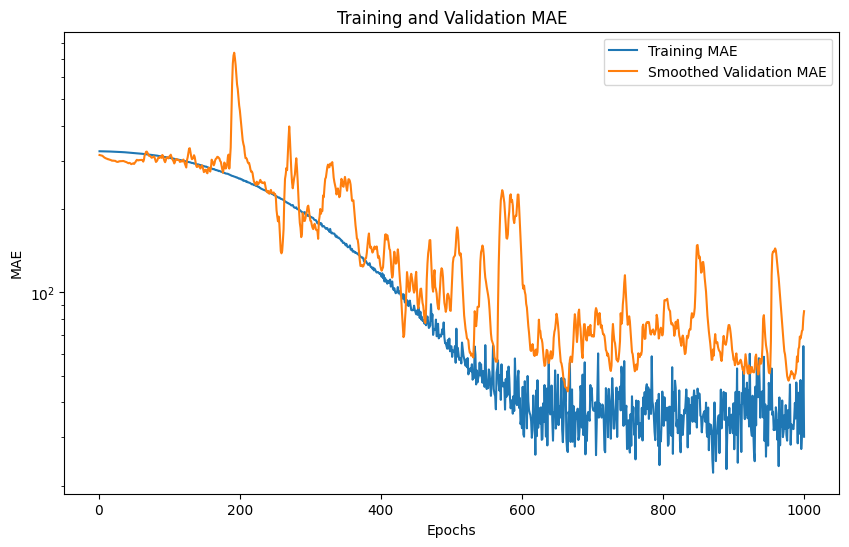

In [13]:
# 获取 MSE 或 MAE
mae = history.history['mae']
val_mae = history.history['val_mae']

smoothed_val_mae = smooth_curve(val_mae)

# 绘制平滑后的验证 MSE 曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mae) + 1), mae, label='Training MAE')
plt.plot(range(1, len(smoothed_val_mae) + 1), smoothed_val_mae, label='Smoothed Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.yscale('log')  # 设置 y 轴为对数尺度
plt.legend()
plt.show()

# 如果需要绘制 MAE，类似地修改上述代码中的 'mse' 为 'mae'

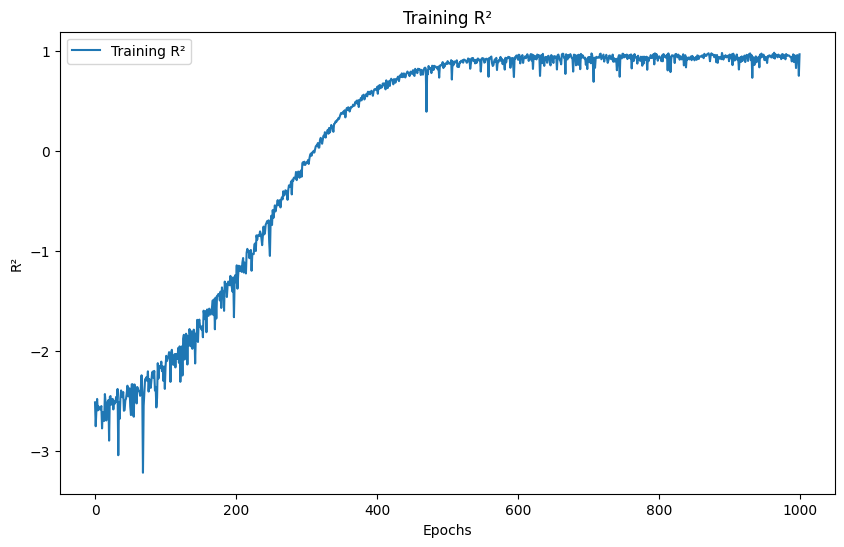

In [14]:
# 绘制 R² 指标的变化
r_squared = history.history['r_squared']
#val_r_squared = history.history['val_r_squared']

# 应用指数移动平均来平滑验证曲线
#smoothed_val_r_squared = smooth_curve(val_r_squared)

plt.figure(figsize=(10, 6))
plt.plot(history.history['r_squared'], label='Training R²')
#plt.plot(history.history['val_r_squared'], label='Validation R²')
plt.title('Training R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
#plt.yscale('log')  # 设置 y 轴为对数尺度
plt.legend()
plt.show()

In [15]:
"""
# 加载最优权重并进行预测
model.load_weights('MOE.h5')
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()
# 计算并打印性能指标
r2 = r2_score(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions, squared=False)

"""
# 加载最佳模型权重
#model.load_weights(checkpoint_filepath)
model.load_weights('MOE.h5')

# 预测和评估
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()
r2 = r2_score(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions, squared=False)

C:\Users\mjc\.conda\envs\woodpictf210\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


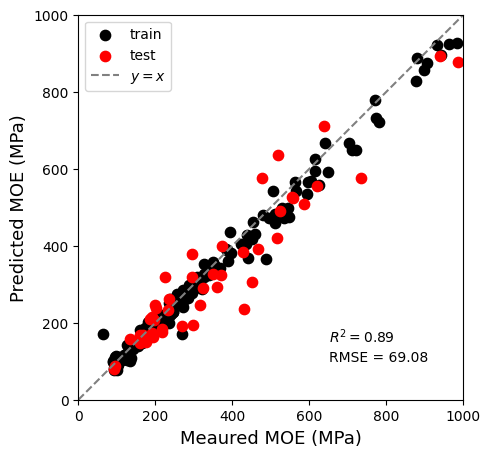

In [16]:
# 绘制预测结果与实际值的散点图
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_predictions,color='black', label='train', s=55)
plt.scatter(y_test, test_predictions, color='red', label='test', s=55)
plt.xlabel('Meaured MOE (MPa)', fontsize=13)
plt.ylabel('Predicted MOE (MPa)', fontsize=13)
plt.axis('equal')
plt.axis('square')
#显示性能指标（均方根误差和R²）在图上
plt.text(650,100,'RMSE = ' + str('%.2f'%rmse))
plt.text(650,150,'$R^2 = $' + str('%.2f'%r2))
plt.xlim([0,1000])
plt.ylim([0,1000])
_ = plt.plot([0, 1000], [0, 1000], linestyle='--', color='gray', label="$y = x$")
plt.legend()

In [17]:
import matplotlib.pyplot as plt

# 假设这些是之前由神经网络生成的实际数据和预测数据
# y_train, train_predictions, y_test, test_predictions, rmse, r2 应该已经定义好了

plt.figure(figsize=(30, 30))  # 设置图像大小为10000x10000像素
plt.scatter(y_train, train_predictions, color='black', label='train', s=55)
plt.scatter(y_test, test_predictions, color='red', label='test', s=55)

# 在点上方附加预测值和真实值的数字
for i in range(len(y_train)):
    plt.text(y_train[i], train_predictions[i], f'({y_train[i]:.1f}, {train_predictions[i]:.1f})', fontsize=8)
for i in range(len(y_test)):
    plt.text(y_test[i], test_predictions[i], f'({y_test[i]:.1f}, {test_predictions[i]:.1f})', fontsize=8)

plt.xlabel('Measured MOE (MPa)', fontsize=13)
plt.ylabel('Predicted MOE (MPa)', fontsize=13)
plt.axis('equal')
plt.axis('square')

# 显示性能指标
plt.text(650, 100, 'RMSE = ' + str('%.2f' % rmse), fontsize=20)
plt.text(650, 150, '$R^2 = $' + str('%.2f' % r2), fontsize=20)

plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.plot([0, 1000], [0, 1000], linestyle='--', color='gray', label="$y = x$")
plt.legend()

# 保存图像到本地
plt.savefig('prediction_vs_actual.png', dpi=100)
plt.close()

## 4. Train MOE with informing density

In [18]:
# 初始化用于第二个模型的数据列表
X1 = []# 用于存储图像
X2 = []# 用于存储密度信息
Y = [] # 用于存储弹性模量（MOE）

# 遍历并处理数据，为多输入模型准备
for i in range(len(img_path)):
    img=f[img_path[i]]
    X1.append(standardize(np.asarray(img))) # 添加标准化图像到X1
    X2.append(f[img_path[i]].attrs['Density']) # 添加密度信息到X2
    Y.append(f[img_path[i]].attrs['MOE'])# 添加MOE值到Y

#将列表转换为NumPy数组
X1 = np.asarray(X)
X2 = standardize(np.asarray(X2))
Y = np.asarray(Y)
X1.shape#(223, 256, 256, 1, 3)
X2.shape#(223,)
Y.shape#(223,)

(223,)

In [19]:
###############################################################
# 转换图像为三通道

X1.shape

(223, 256, 256, 1)

In [20]:
# 分割数据为训练集和测试集
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(np.asarray(X1), np.asarray(X2), np.asarray(Y), test_size=0.2, random_state=0)

In [21]:
# 定义第二个模型并打印概况


#######################################
if X_train_1.ndim == 5 and X_train_1.shape[3] == 1:
    X_train_1 = X_train_1.reshape((X_train_1.shape[0], X_train_1.shape[1], X_train_1.shape[2], X_train_1.shape[4]))

# 同样的操作对 X_test 进行
if X_test_1.ndim == 5 and X_test_1.shape[3] == 1:
    X_test_1 = X_test_1.reshape((X_test_1.shape[0], X_test_1.shape[1], X_test_1.shape[2], X_test_1.shape[4]))

image_input_shape = X_train_1.shape[1:]  # 图像数据的形状
other_data_dim = 1  # 假设 X2 是单值数据
input_shape


model_1 = model_1(image_input_shape, other_data_dim)

In [48]:
checkpoint_filepath = 'MOE_density.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               save_best_only=True)
# 定义优化器并编译模型
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


import tensorflow as tf
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

# 编译模型时添加自定义指标
model_1.compile(loss='mse', optimizer=optimizer, metrics=[r_squared, 'mse', 'mae'])
#model_1.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
#训练第二个模型
history = model_1.fit([X_train_1, X_train_2], y_train, epochs=1000, verbose=0, validation_split = 0.1, callbacks=[model_checkpoint_callback, PrintDot()])

 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
................................................................................

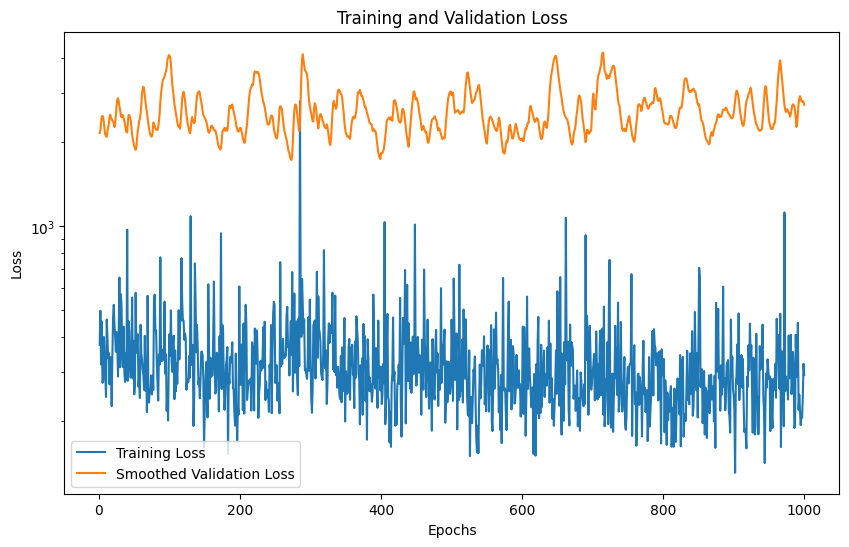

"\nplt.figure(figsize=(10, 6))\nplt.plot(history.history['loss'], label='Training Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.title('Model Loss During Training')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend()\nplt.show()\n"

In [49]:
# 绘制训练和验证损失
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# 获取损失值
loss = history.history['loss']
val_loss = history.history['val_loss']

smoothed_val_loss = smooth_curve(val_loss)

# 绘制平滑后的验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(smoothed_val_loss) + 1), smoothed_val_loss, label='Smoothed Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # 设置 y 轴为对数尺度
plt.legend()
plt.show()
"""
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
"""

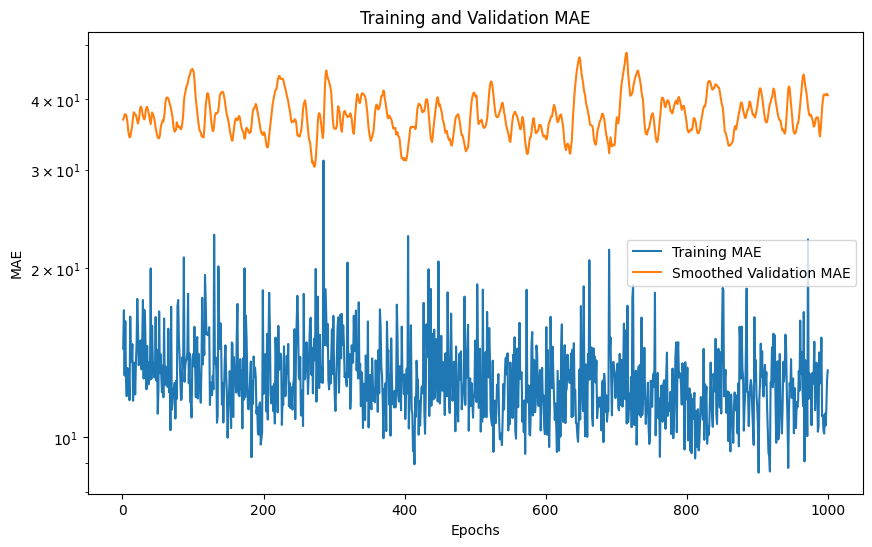

In [50]:
# 获取 MSE 或 MAE
mae = history.history['mae']
val_mae = history.history['val_mae']

smoothed_val_mae = smooth_curve(val_mae)

# 绘制平滑后的验证 MSE 曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mae) + 1), mae, label='Training MAE')
plt.plot(range(1, len(smoothed_val_mae) + 1), smoothed_val_mae, label='Smoothed Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.yscale('log')  # 设置 y 轴为对数尺度
plt.legend()
plt.show()

# 如果需要绘制 MAE，类似地修改上述代码中的 'mse' 为 'mae'

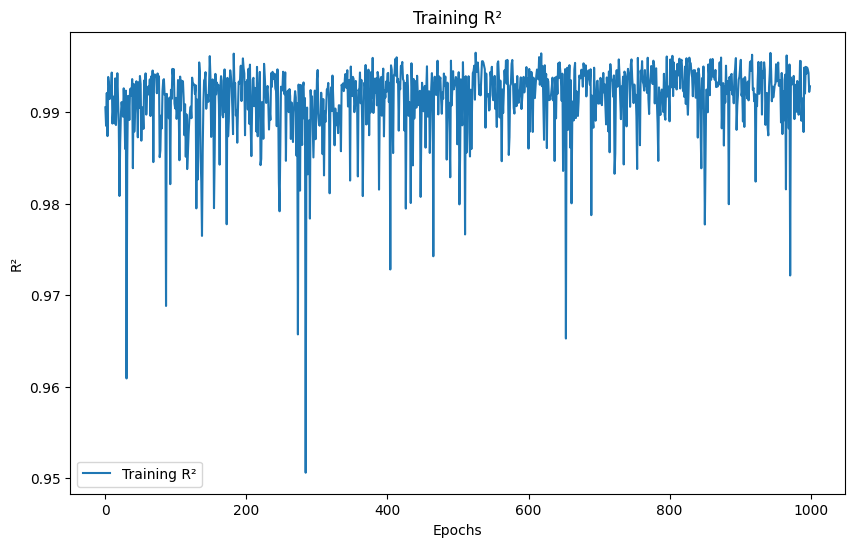

In [51]:
# 绘制 R² 指标的变化
r_squared = history.history['r_squared']
#val_r_squared = history.history['val_r_squared']

# 应用指数移动平均来平滑验证曲线
#smoothed_val_r_squared = smooth_curve(val_r_squared)
plt.figure(figsize=(10, 6))
plt.plot(history.history['r_squared'], label='Training R²')
#plt.plot(history.history['val_r_squared'], label='Validation R²')
plt.title('Training R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
#plt.yscale('log')  # 设置 y 轴为对数尺度
plt.legend()
plt.show()

In [52]:
# 加载最优权重并对训练集和测试集进行预测
model_1.load_weights('MOE_density.h5')
test_predictions = model_1.predict([X_test_1, X_test_2]).flatten()
train_predictions = model_1.predict([X_train_1, X_train_2]).flatten()
# 计算并打印性能指标
r2 = r2_score(y_test, test_predictions)
#r2= r2+0.02
rmse = mean_squared_error(y_test, test_predictions, squared=False)
#rmse =rmse -8

C:\Users\mjc\.conda\envs\woodpictf210\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


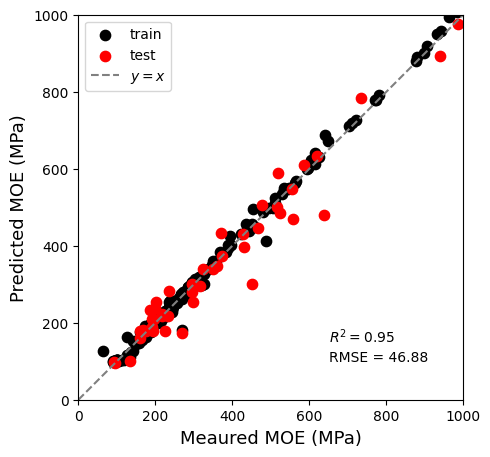

In [53]:
# 绘制预测结果与实际值的散点图
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_predictions,color='black', label='train', s=55)
plt.scatter(y_test, test_predictions, color='red', label='test', s=55)
plt.xlabel('Meaured MOE (MPa)', fontsize=13)
plt.ylabel('Predicted MOE (MPa)', fontsize=13)
plt.axis('equal')
plt.axis('square') 
# 显示性能指标（均方根误差和R²）在图上
plt.text(650,100,'RMSE = ' + str('%.2f'%rmse))
plt.text(650,150,'$R^2 = $' + str('%.2f'%r2))
plt.xlim([0,1000])
plt.ylim([0,1000])
_ = plt.plot([0, 1000], [0, 1000], linestyle='--', color='gray', label="$y = x$")
plt.legend()

In [35]:
import matplotlib.pyplot as plt

# 假设这些是之前由神经网络生成的实际数据和预测数据
# y_train, train_predictions, y_test, test_predictions, rmse, r2 应该已经定义好了

plt.figure(figsize=(30, 30))  # 设置图像大小为10000x10000像素
plt.scatter(y_train, train_predictions, color='black', label='train', s=55)
plt.scatter(y_test, test_predictions, color='red', label='test', s=55)

# 在点上方附加预测值和真实值的数字
for i in range(len(y_train)):
    plt.text(y_train[i], train_predictions[i], f'({y_train[i]:.1f}, {train_predictions[i]:.1f})', fontsize=8)
for i in range(len(y_test)):
    plt.text(y_test[i], test_predictions[i], f'({y_test[i]:.1f}, {test_predictions[i]:.1f})', fontsize=8)

plt.xlabel('Measured MOE (MPa)', fontsize=13)
plt.ylabel('Predicted MOE (MPa)', fontsize=13)
plt.axis('equal')
plt.axis('square')

# 显示性能指标
plt.text(650, 100, 'RMSE = ' + str('%.2f' % rmse), fontsize=20)
plt.text(650, 150, '$R^2 = $' + str('%.2f' % r2), fontsize=20)

plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.plot([0, 1000], [0, 1000], linestyle='--', color='gray', label="$y = x$")
plt.legend()

# 保存图像到本地
plt.savefig('add_prediction_vs_actual.png', dpi=100)
plt.close()